## 0 - Librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import label_binarize
import seaborn as sns
from tensorflow.keras import optimizers
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.layers import BatchNormalization, RandomRotation, RandomTranslation, RandomZoom, RandomBrightness
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.config import run_functions_eagerly

2025-09-21 23:04:21.228742: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-21 23:04:20.771147: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-21 23:04:22.611797: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
run_functions_eagerly((True))

## 1 - Data Preparation

In [3]:
X_train = np.load("Images/train_images.npy") 
y_train = np.load("Images/train_labels.npy") 
X_test = np.load("Images/test_images.npy")  
y_test = np.load("Images/test_labels.npy")  

In [4]:
print(f'Shape of data X_train:{X_train.shape}\n')
print(f'Shape of data y_train:{y_train.shape}\n')
print(f'Shape of data X_test:{X_test.shape}\n')
print(f'Shape of data y_test:{y_test.shape}')

Shape of data X_train:(60000, 28, 28, 1)

Shape of data y_train:(60000,)

Shape of data X_test:(10000, 28, 28, 1)

Shape of data y_test:(10000,)


In [5]:
# Normalize images
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
print(f'Shape of data X_train:{X_train.shape}\n')
print(f'Shape of data X_test:{X_test.shape}\n')

Shape of data X_train:(60000, 28, 28, 1)

Shape of data X_test:(10000, 28, 28, 1)



In [6]:
# Reshape images for CNN model
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)
print(f'Shape of data X_train_cnn :{X_train_cnn .shape}\n')
print(f'Shape of data X_test_cnn :{X_test_cnn .shape}\n')

Shape of data X_train_cnn :(60000, 28, 28, 1)

Shape of data X_test_cnn :(10000, 28, 28, 1)



## 2 - Data Viz

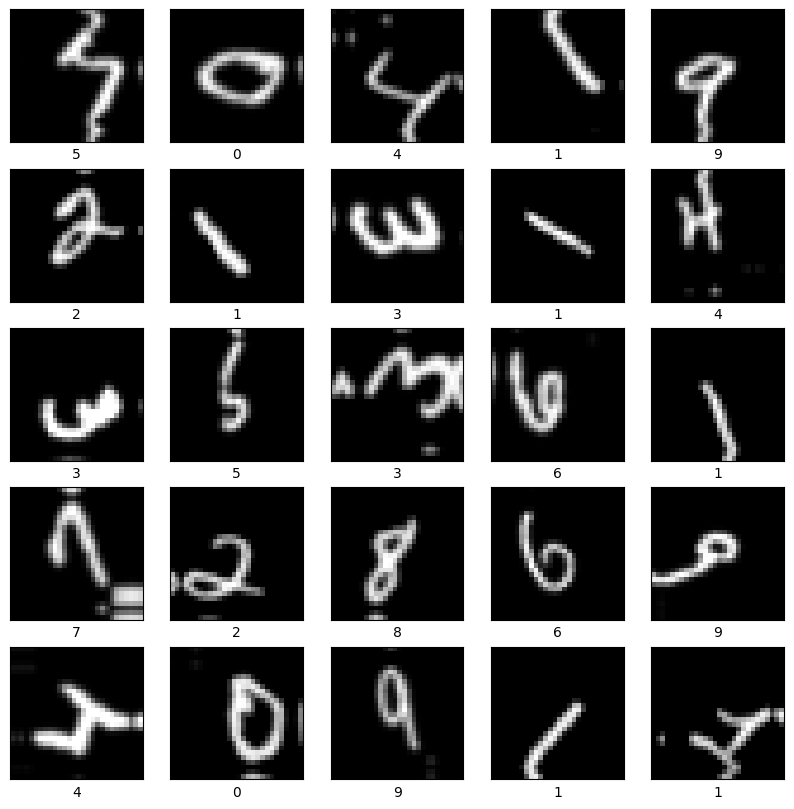

In [7]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.gray)
    plt.xlabel(y_train[i])
plt.show()

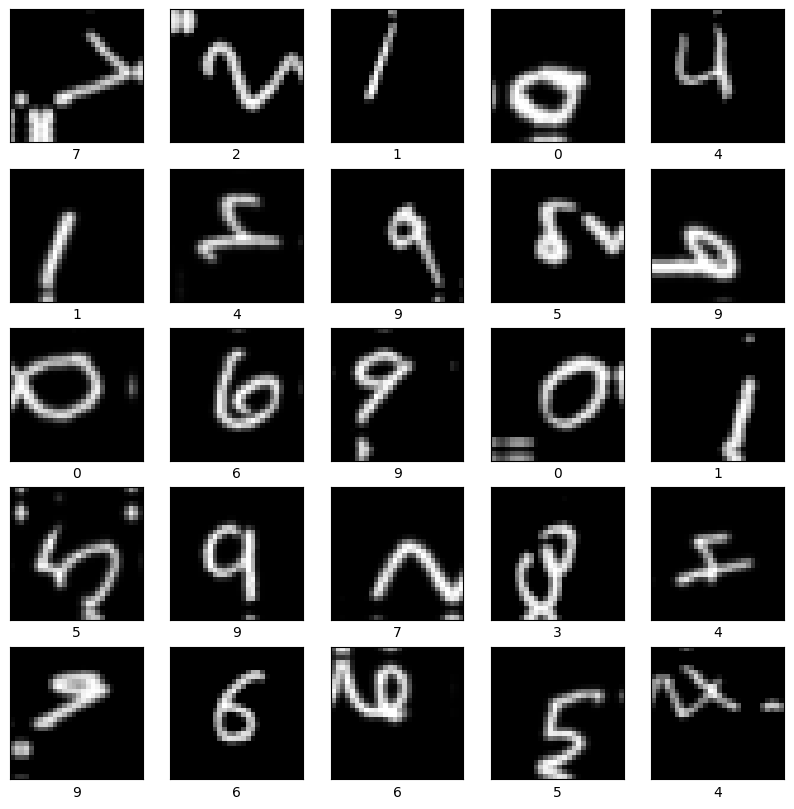

In [8]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap=plt.cm.gray)
    plt.xlabel(y_test[i])
plt.show()

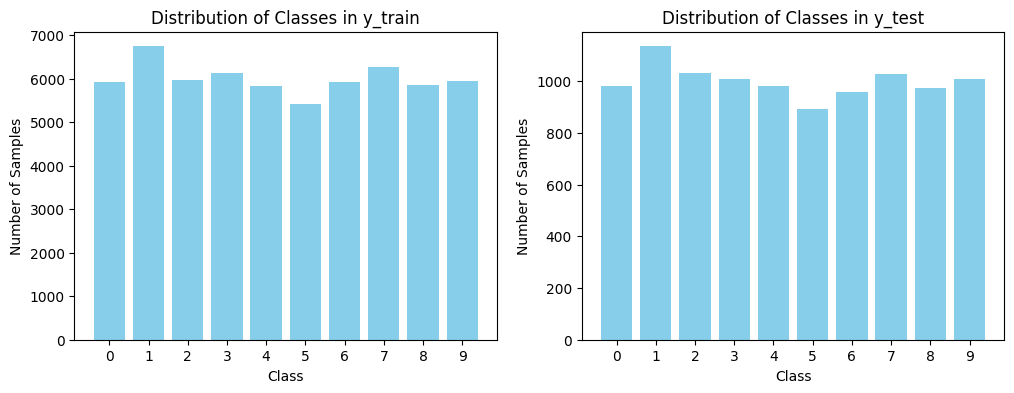

In [9]:
unique_classes_train, counts_train = np.unique(y_train, return_counts=True)
unique_classes_test, counts_test = np.unique(y_test, return_counts=True)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(unique_classes_train, counts_train, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_train')
plt.xticks(unique_classes_train)  

plt.subplot(1, 2, 2)
plt.bar(unique_classes_test, counts_test, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_test')
plt.xticks(unique_classes_test)  
plt.show()

## 3 - CNN Modele

### Parameters

In [10]:
# Parameters
epochs_cnn = 15
batch_size_cnn = 64
k_folds = 5
learning_rate_cnn = 0.001
metric_cnn = ["accuracy"]  #"SparseCategoricalAccuracy"
monitor_callback_cnn = "val_loss"
patience_callback_cnn = 4
mode_callback_cnn = None  # "max"

### Others functions

In [11]:
# To have the same modifications that the perturbations
data_augmentation = Sequential([
    RandomRotation(0.2),
    RandomTranslation(0.2, 0.2),
    RandomZoom(0.2),
    RandomBrightness((-0.2, 0.2), [0.0, 1.0])
])

E0000 00:00:1758488665.779437    1016 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1758488665.785839    1016 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Modele

In [12]:
def create_cnn_model():
    cnn_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28,28,1)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(10, activation='softmax')
        ])

    cnn_model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate_cnn),
                    loss='sparse_categorical_crossentropy',
                    metrics=metric_cnn
        )
    return cnn_model

In [13]:
skf = StratifiedKFold(n_splits=k_folds, shuffle=True)
fold_results = []
best_cnn_model = None
best_accuracy = 0.0
best_loss = 0.0
best_cnn_history = None
best_histories = [(None, 0.0) for i in range (k_folds)]

# Cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_cnn, y_train)):
    print(f"\nFold {fold + 1}/{k_folds}")


    X_train_fold, X_val_fold = X_train_cnn[train_idx], X_train_cnn[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # New model for the current fold
    cnn_model = create_cnn_model()

    # Train the model
    history = cnn_model.fit(
        X_train_fold, y_train_fold,
        epochs=epochs_cnn,
        batch_size=batch_size_cnn,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[EarlyStopping(monitor=monitor_callback_cnn, patience=patience_callback_cnn, mode=mode_callback_cnn, restore_best_weights=True)],
        verbose=1
    )

    # Evaluate the model
    val_loss, val_accuracy = cnn_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation accuracy for fold {fold + 1}: {val_accuracy:.4f}")

    # Store the results
    fold_results.append((val_accuracy, val_loss))

    if val_accuracy > best_histories[fold][1] :
        best_histories[fold] = (cnn_model, val_accuracy, val_loss, history)

    # Kepp the best model
    if val_accuracy > best_accuracy :
        best_accuracy = val_accuracy
        best_loss = val_loss
        best_cnn_model = cnn_model
        best_cnn_history = history


/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 1/5


/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/keras/src/callbacks/early_stopping.py:77: UserWarning: EarlyStopping mode 'None' is unknown, fallback to auto mode.
  super().__init__(monitor, mode, min_delta=min_delta)
/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 223s 297ms/step - accuracy: 0.6119 - loss: 1.2255 - val_accuracy: 0.8489 - val_loss: 0.5143
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 213s 284ms/step - accuracy: 0.8690 - loss: 0.4165 - val_accuracy: 0.9168 - val_loss: 0.2637
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 214s 285ms/step - accuracy: 0.9113 - loss: 0.2862 - val_accuracy: 0.9168 - val_loss: 0.2728
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 215s 287ms/step - accuracy: 0.9298 - loss: 0.2289 - val_accuracy: 0.8907 - val_loss: 0.3468
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 222s 296ms/step - accuracy: 0.9403 - loss: 0.1959 - val_accuracy: 0.9451 - val_loss: 0.1838
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 231s 307ms/step - accuracy: 0.9486 - loss: 0.1703 - val_accuracy: 0.9644 - val_loss: 0.1197
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 222s 295ms/step - accuracy: 0.9512 - loss: 0.1597 - val_accuracy: 0.9321 - val_loss: 0.2037
Epoch 8/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 223s 297ms/step - accuracy: 0.9542 -

In [14]:
# Print the result
print("\n--- Cross-Validation Results ---")
for i, (accuracy, loss) in enumerate(fold_results):
    print(f"Fold {i + 1}: Validation accuracy = {accuracy:.4f}")
    print(f"Fold {i + 1}: Validation loss = {loss:.4f}")

print(f"\nBest validation accuracy: {best_accuracy:.4f}")
print(f"\nBest validation loss: {best_loss:.4f}")

# Best Model
print("\nBest model summary:")
best_cnn_model.summary()


accuracies = [result[0] for result in fold_results]
losses = [result[1] for result in fold_results]

# Variance and Mean
mean_accuracy = np.mean(accuracies)
variance_accuracy = np.var(accuracies, ddof=1)
std_accuracy = np.std(accuracies, ddof=1)

mean_loss = np.mean(losses)
variance_loss = np.var(losses, ddof=1)
std_loss = np.std(losses, ddof=1)


print(f"Mean of accuracies : {mean_accuracy:.4f}")
print(f"Variance of accuracies : {variance_accuracy:.6f}")
print(f"Std of accuracies : {std_accuracy:.4f}")

print(f"\nMean of losses : {mean_loss:.4f}")
print(f"Variance of losses : {variance_loss:.6f}")
print(f"Std of losses : {std_loss:.4f}")


--- Cross-Validation Results ---
Fold 1: Validation accuracy = 0.9762
Fold 1: Validation loss = 0.0865
Fold 2: Validation accuracy = 0.9562
Fold 2: Validation loss = 0.1423
Fold 3: Validation accuracy = 0.9682
Fold 3: Validation loss = 0.1088
Fold 4: Validation accuracy = 0.9682
Fold 4: Validation loss = 0.1067
Fold 5: Validation accuracy = 0.9619
Fold 5: Validation loss = 0.1223

Best validation accuracy: 0.9762

Best validation loss: 0.0865

Best model summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,314,368 (5.01 MB)

 Trainable params: 437,738 (1.67 MB)

 Non-trainable params: 1,152 (4.50 KB)

 Optimizer params: 875,478 (3.34 MB)

Mean of accuracies : 0.9661
Variance of accuracies : 0.000057
Std of accuracies : 0.0076

Mean of losses : 0.1133
Variance of losses : 0.000426
Std of losses : 0.0206


### Results

#### For the best fold

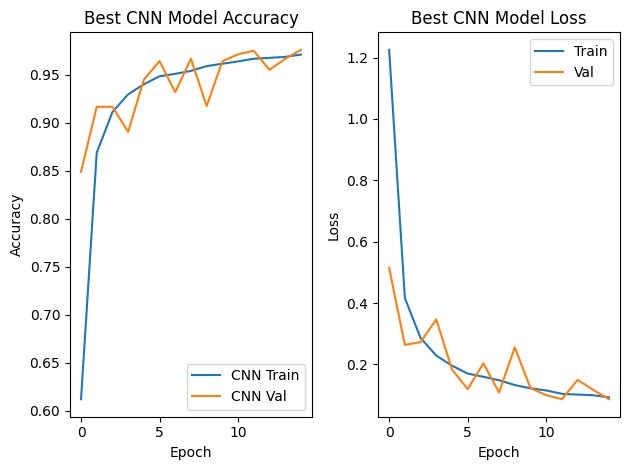

In [15]:
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(best_cnn_history.history["accuracy"], label='CNN Train')
plt.plot(best_cnn_history.history['val_accuracy'], label='CNN Val')
plt.title('Best CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(best_cnn_history.history['loss'], label='Train')
plt.plot(best_cnn_history.history['val_loss'], label='Val')
plt.title('Best CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Predict classes using the cnn model
#best_cnn_model = best_histories[4][0]
y_pred_cnn = best_cnn_model.predict(X_test_cnn)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step


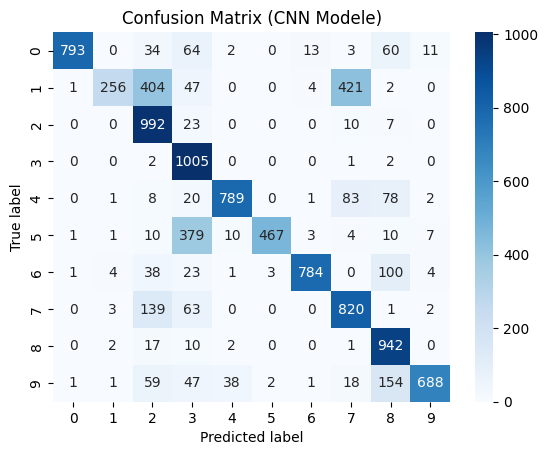

Class 0:
  Sensitivity (SEV): 0.8092
  Specificity (SPE): 0.9996
  Accuracy: 0.9809
  F1-score: 0.8925

Class 1:
  Sensitivity (SEV): 0.2256
  Specificity (SPE): 0.9986
  Accuracy: 0.9109
  F1-score: 0.3649

Class 2:
  Sensitivity (SEV): 0.9612
  Specificity (SPE): 0.9207
  Accuracy: 0.9249
  F1-score: 0.7254

Class 3:
  Sensitivity (SEV): 0.9950
  Specificity (SPE): 0.9248
  Accuracy: 0.9319
  F1-score: 0.7469

Class 4:
  Sensitivity (SEV): 0.8035
  Specificity (SPE): 0.9941
  Accuracy: 0.9754
  F1-score: 0.8651

Class 5:
  Sensitivity (SEV): 0.5235
  Specificity (SPE): 0.9995
  Accuracy: 0.9570
  F1-score: 0.6848

Class 6:
  Sensitivity (SEV): 0.8184
  Specificity (SPE): 0.9976
  Accuracy: 0.9804
  F1-score: 0.8889

Class 7:
  Sensitivity (SEV): 0.7977
  Specificity (SPE): 0.9397
  Accuracy: 0.9251
  F1-score: 0.6865

Class 8:
  Sensitivity (SEV): 0.9671
  Specificity (SPE): 0.9541
  Accuracy: 0.9554
  F1-score: 0.8086

Class 9:
  Sensitivity (SEV): 0.6819
  Specificity (SPE): 0.9971

In [17]:
# Confusion matrix
matrix = confusion_matrix(y_test, y_pred_classes_cnn)  # Compare true labels (y_test) and predicted labels (y_pred_classes_dense)

# Plot confusion matrix
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (CNN Modele)')
plt.show()

# Calculate Sensitivity (SEV) and Specificity (SPE) for each class
for i in range(matrix.shape[0]):
    tp = matrix[i, i]
    fn = np.sum(matrix[i, :]) - tp
    fp = np.sum(matrix[:, i]) - tp
    tn = np.sum(matrix) - tp - fn - fp
    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0  # F1-score
    sev = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity (Recall)
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
    accuracy = (tn + tp) / (tp + fn + tn + fp)
    print(f'Class {i}:')
    print(f'  Sensitivity (SEV): {sev:.4f}')
    print(f'  Specificity (SPE): {spe:.4f}')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  F1-score: {f1:.4f}\n')

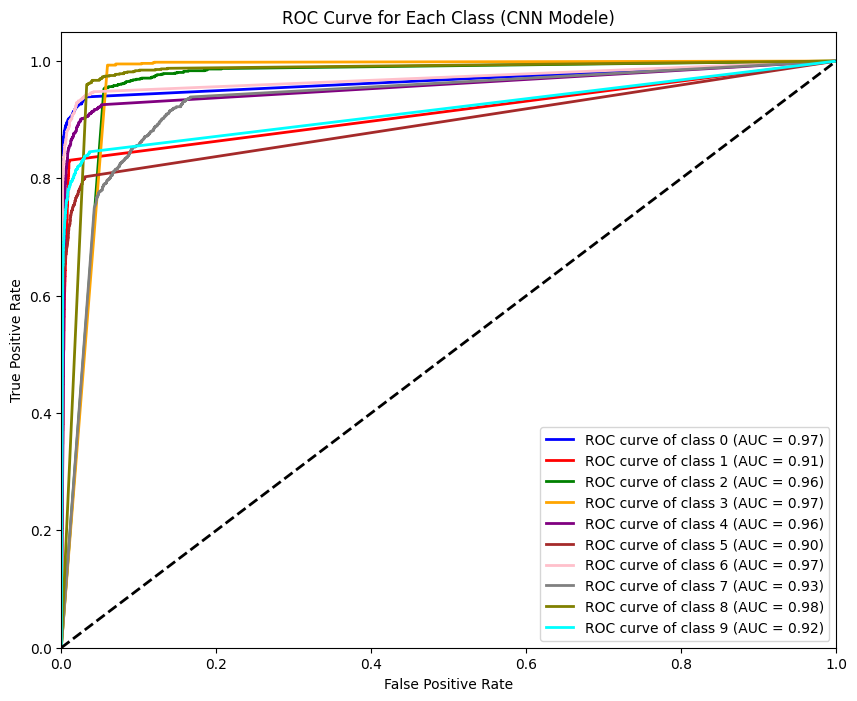

In [18]:
# Binarize the output for ROC curve (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_cnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (CNN Modele)')
plt.legend(loc="lower right")
plt.show()

#### For all the folds

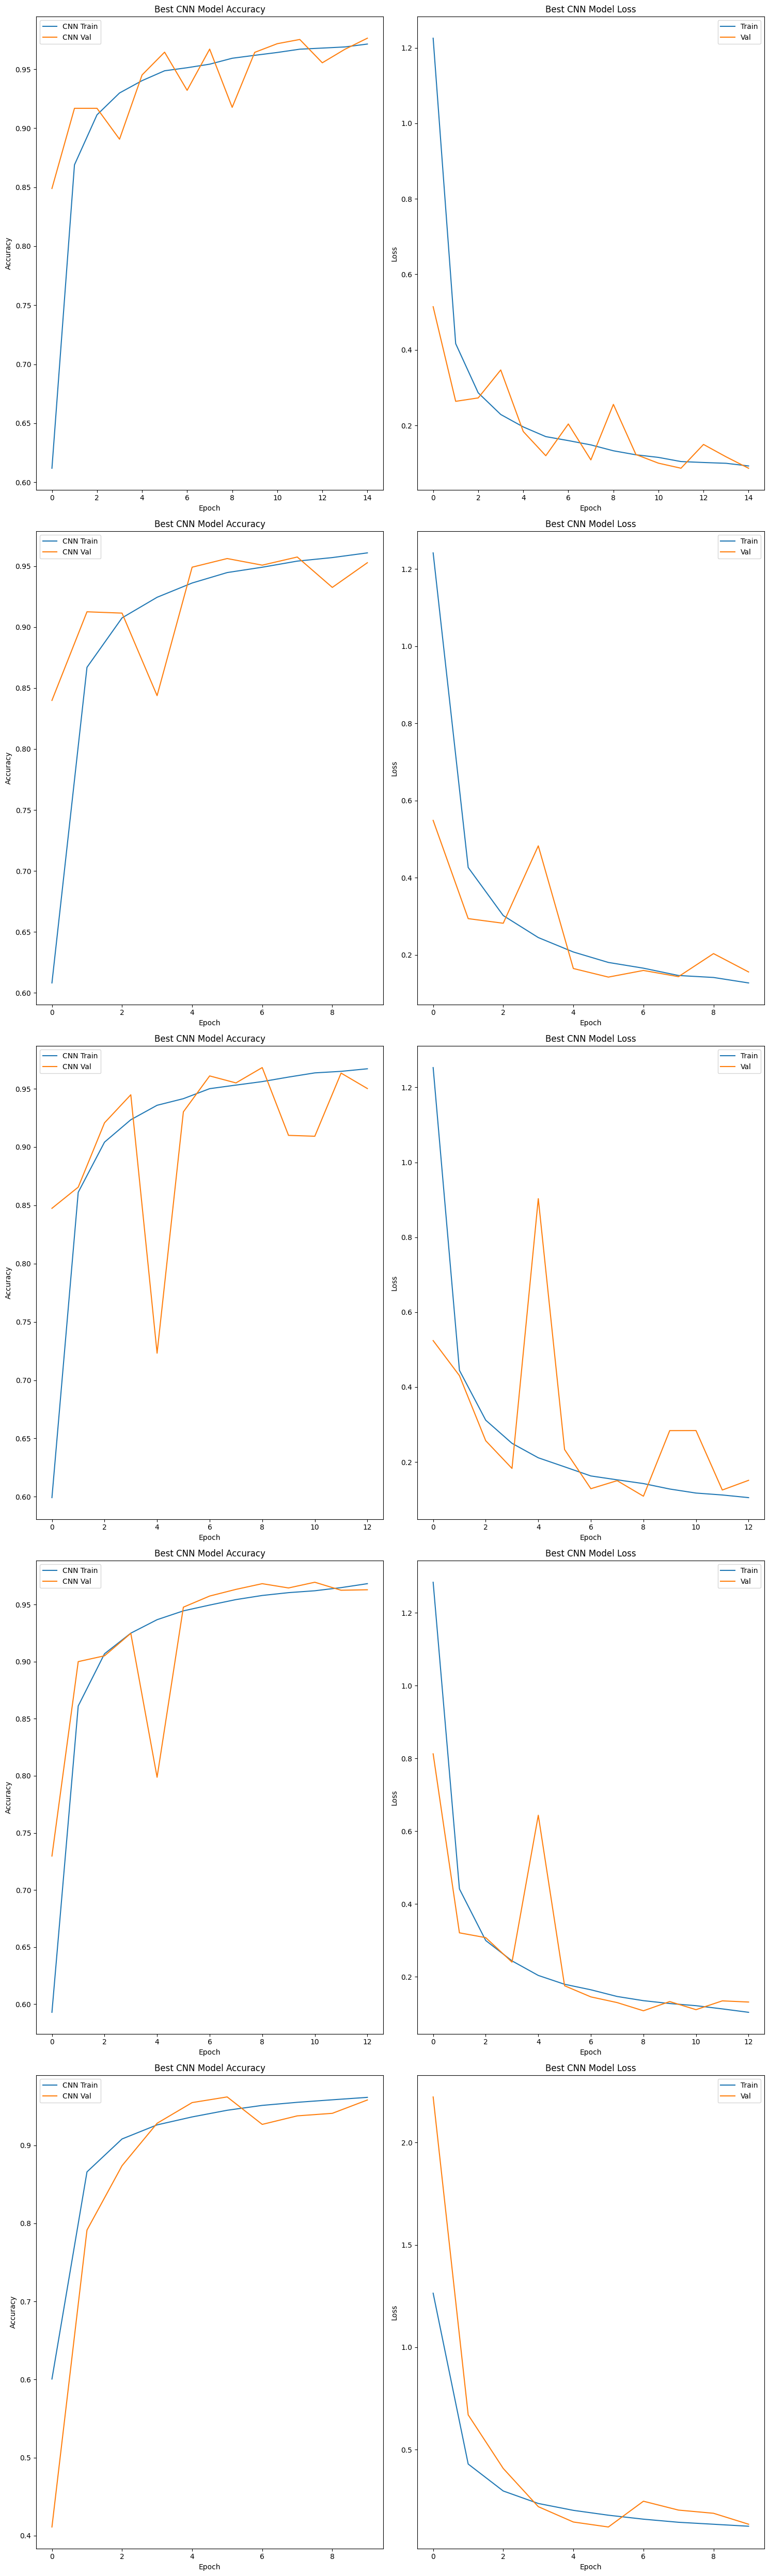

In [19]:
plt.figure(figsize=(15, 10*k_folds))
for fold in range (k_folds) :
    cnn_model = best_histories[fold][3]
    # Accuracy
    plt.subplot(k_folds, 2, 2*fold+1)
    plt.plot(cnn_model.history["accuracy"], label='CNN Train')
    plt.plot(cnn_model.history['val_' + "accuracy"], label='CNN Val')
    plt.title('Best CNN Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Loss
    plt.subplot(k_folds, 2, 2*fold+2)
    plt.plot(cnn_model.history['loss'], label='Train')
    plt.plot(cnn_model.history['val_loss'], label='Val')
    plt.title('Best CNN Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
plt.show()


  1/313 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step

-------- Fold 1: --------

Class 0:
  Sensitivity (SEV): 0.8092
  Specificity (SPE): 0.9996
  Accuracy: 0.9809
  F1-score: 0.8925

Class 1:
  Sensitivity (SEV): 0.2256
  Specificity (SPE): 0.9986
  Accuracy: 0.9109
  F1-score: 0.3649

Class 2:
  Sensitivity (SEV): 0.9612
  Specificity (SPE): 0.9207
  Accuracy: 0.9249
  F1-score: 0.7254

Class 3:
  Sensitivity (SEV): 0.9950
  Specificity (SPE): 0.9248
  Accuracy: 0.9319
  F1-score: 0.7469

Class 4:
  Sensitivity (SEV): 0.8035
  Specificity (SPE): 0.9941
  Accuracy: 0.9754
  F1-score: 0.8651

Class 5:
  Sensitivity (SEV): 0.5235
  Specificity (SPE): 0.9995
  Accuracy: 0.9570
  F1-score: 0.6848

Class 6:
  Sensitivity (SEV): 0.8184
  Specificity (SPE): 0.9976
  Accuracy: 0.9804
  F1-score: 0.8889

Class 7:
  Sensitivity (SEV): 0.7977
  Specificity (SPE): 0.9397
  Accuracy: 0.9251
  F1-score: 0.6865

Class 8:
  Sensitivity (SEV): 0.9671
  Specificity (SPE): 0.9541
  Accuracy: 0.9554
  F1-score: 0

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step

-------- Fold 2: --------

Class 0:
  Sensitivity (SEV): 0.5765
  Specificity (SPE): 0.9999
  Accuracy: 0.9584
  F1-score: 0.7309

Class 1:
  Sensitivity (SEV): 0.0414
  Specificity (SPE): 0.9999
  Accuracy: 0.8911
  F1-score: 0.0795

Class 2:
  Sensitivity (SEV): 0.8895
  Specificity (SPE): 0.9325
  Accuracy: 0.9281
  F1-score: 0.7186

Class 3:
  Sensitivity (SEV): 0.9881
  Specificity (SPE): 0.8044
  Accuracy: 0.8230
  F1-score: 0.5300

Class 4:
  Sensitivity (SEV): 0.8035
  Specificity (SPE): 0.9439
  Accuracy: 0.9301
  F1-score: 0.6930

Class 5:
  Sensitivity (SEV): 0.7769
  Specificity (SPE): 0.9255
  Accuracy: 0.9122
  F1-score: 0.6122

Class 6:
  Sensitivity (SEV): 0.4593
  Specificity (SPE): 0.9967
  Accuracy: 0.9452
  F1-score: 0.6162

Class 7:
  Sensitivity (SEV): 0.4290
  Specificity (SPE): 0.9687
  Accuracy: 0.9132
  F1-score: 0.5040

Class 8:
  Sensitivity (SEV): 0.7567
  Specificity (SPE): 0.9634
  Accuracy: 0.9433
  F1-score: 0

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step

-------- Fold 3: --------

Class 0:
  Sensitivity (SEV): 0.3714
  Specificity (SPE): 1.0000
  Accuracy: 0.9384
  F1-score: 0.5417

Class 1:
  Sensitivity (SEV): 0.0863
  Specificity (SPE): 1.0000
  Accuracy: 0.8963
  F1-score: 0.1590

Class 2:
  Sensitivity (SEV): 0.6541
  Specificity (SPE): 0.9768
  Accuracy: 0.9435
  F1-score: 0.7050

Class 3:
  Sensitivity (SEV): 0.9990
  Specificity (SPE): 0.7258
  Accuracy: 0.7534
  F1-score: 0.4500

Class 4:
  Sensitivity (SEV): 0.7016
  Specificity (SPE): 0.9854
  Accuracy: 0.9575
  F1-score: 0.7643

Class 5:
  Sensitivity (SEV): 0.2108
  Specificity (SPE): 0.9942
  Accuracy: 0.9243
  F1-score: 0.3319

Class 6:
  Sensitivity (SEV): 0.3361
  Specificity (SPE): 0.9999
  Accuracy: 0.9363
  F1-score: 0.5027

Class 7:
  Sensitivity (SEV): 0.5681
  Specificity (SPE): 0.9104
  Accuracy: 0.8752
  F1-score: 0.4834

Class 8:
  Sensitivity (SEV): 0.8994
  Specificity (SPE): 0.9382
  Accuracy: 0.9344
  F1-score: 0

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step

-------- Fold 4: --------

Class 0:
  Sensitivity (SEV): 0.9459
  Specificity (SPE): 0.9984
  Accuracy: 0.9933
  F1-score: 0.9651

Class 1:
  Sensitivity (SEV): 0.5075
  Specificity (SPE): 0.9986
  Accuracy: 0.9429
  F1-score: 0.6686

Class 2:
  Sensitivity (SEV): 0.9186
  Specificity (SPE): 0.9380
  Accuracy: 0.9360
  F1-score: 0.7476

Class 3:
  Sensitivity (SEV): 0.9733
  Specificity (SPE): 0.9882
  Accuracy: 0.9867
  F1-score: 0.9366

Class 4:
  Sensitivity (SEV): 0.9521
  Specificity (SPE): 0.9663
  Accuracy: 0.9649
  F1-score: 0.8420

Class 5:
  Sensitivity (SEV): 0.8823
  Specificity (SPE): 0.9923
  Accuracy: 0.9825
  F1-score: 0.8999

Class 6:
  Sensitivity (SEV): 0.9186
  Specificity (SPE): 0.9931
  Accuracy: 0.9860
  F1-score: 0.9263

Class 7:
  Sensitivity (SEV): 0.6936
  Specificity (SPE): 0.9583
  Accuracy: 0.9311
  F1-score: 0.6742

Class 8:
  Sensitivity (SEV): 0.9610
  Specificity (SPE): 0.9684
  Accuracy: 0.9677
  F1-score: 0.

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step

-------- Fold 5: --------

Class 0:
  Sensitivity (SEV): 0.8551
  Specificity (SPE): 0.9973
  Accuracy: 0.9834
  F1-score: 0.9099

Class 1:
  Sensitivity (SEV): 0.1463
  Specificity (SPE): 1.0000
  Accuracy: 0.9031
  F1-score: 0.2552

Class 2:
  Sensitivity (SEV): 0.9409
  Specificity (SPE): 0.9019
  Accuracy: 0.9059
  F1-score: 0.6736

Class 3:
  Sensitivity (SEV): 0.9743
  Specificity (SPE): 0.9504
  Accuracy: 0.9528
  F1-score: 0.8066

Class 4:
  Sensitivity (SEV): 0.8778
  Specificity (SPE): 0.9885
  Accuracy: 0.9776
  F1-score: 0.8850

Class 5:
  Sensitivity (SEV): 0.7848
  Specificity (SPE): 0.9907
  Accuracy: 0.9723
  F1-score: 0.8348

Class 6:
  Sensitivity (SEV): 0.8539
  Specificity (SPE): 0.9937
  Accuracy: 0.9803
  F1-score: 0.8925

Class 7:
  Sensitivity (SEV): 0.6508
  Specificity (SPE): 0.9448
  Accuracy: 0.9146
  F1-score: 0.6104

Class 8:
  Sensitivity (SEV): 0.9127
  Specificity (SPE): 0.9798
  Accuracy: 0.9733
  F1-score: 0

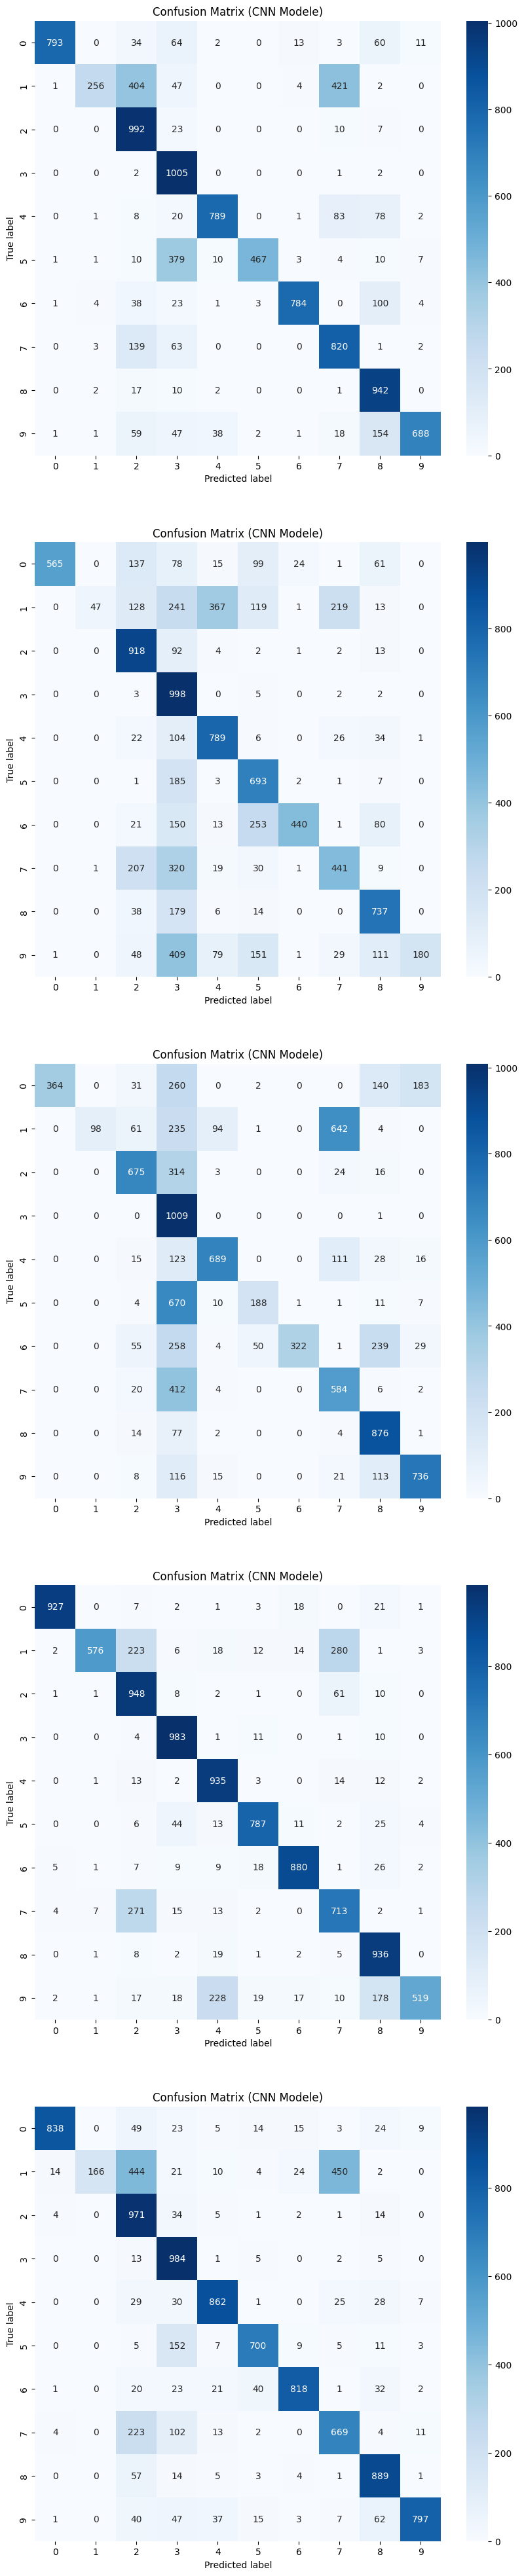

In [20]:
plt.figure(figsize=(10, 10*k_folds))
for fold in range (k_folds) :
    cnn_model = best_histories[fold][0]
    y_pred_cnn = cnn_model.predict(X_test_cnn)
    y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
    # Confusion matrix
    matrix = confusion_matrix(y_test, y_pred_classes_cnn)  # Compare true labels (y_test) and predicted labels (y_pred_classes_dense)
    
    plt.subplot(k_folds, 1, fold+1)
    # Plot confusion matrix
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix (CNN Modele)')

    print(f"\n-------- Fold {fold + 1}: --------\n")

    # Calculate Sensitivity (SEV) and Specificity (SPE) for each class
    for i in range(matrix.shape[0]):
        tp = matrix[i, i]
        fn = np.sum(matrix[i, :]) - tp
        fp = np.sum(matrix[:, i]) - tp
        tn = np.sum(matrix) - tp - fn - fp
        f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0  # F1-score
        sev = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity (Recall)
        spe = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
        accuracy = (tn + tp) / (tp + fn + tn + fp)
        print(f'Class {i}:')
        print(f'  Sensitivity (SEV): {sev:.4f}')
        print(f'  Specificity (SPE): {spe:.4f}')
        print(f'  Accuracy: {accuracy:.4f}')
        print(f'  F1-score: {f1:.4f}\n')

plt.show()

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step
  3/313 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step 

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step
  1/313 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step
  3/313 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step
  3/313 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step 

/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step


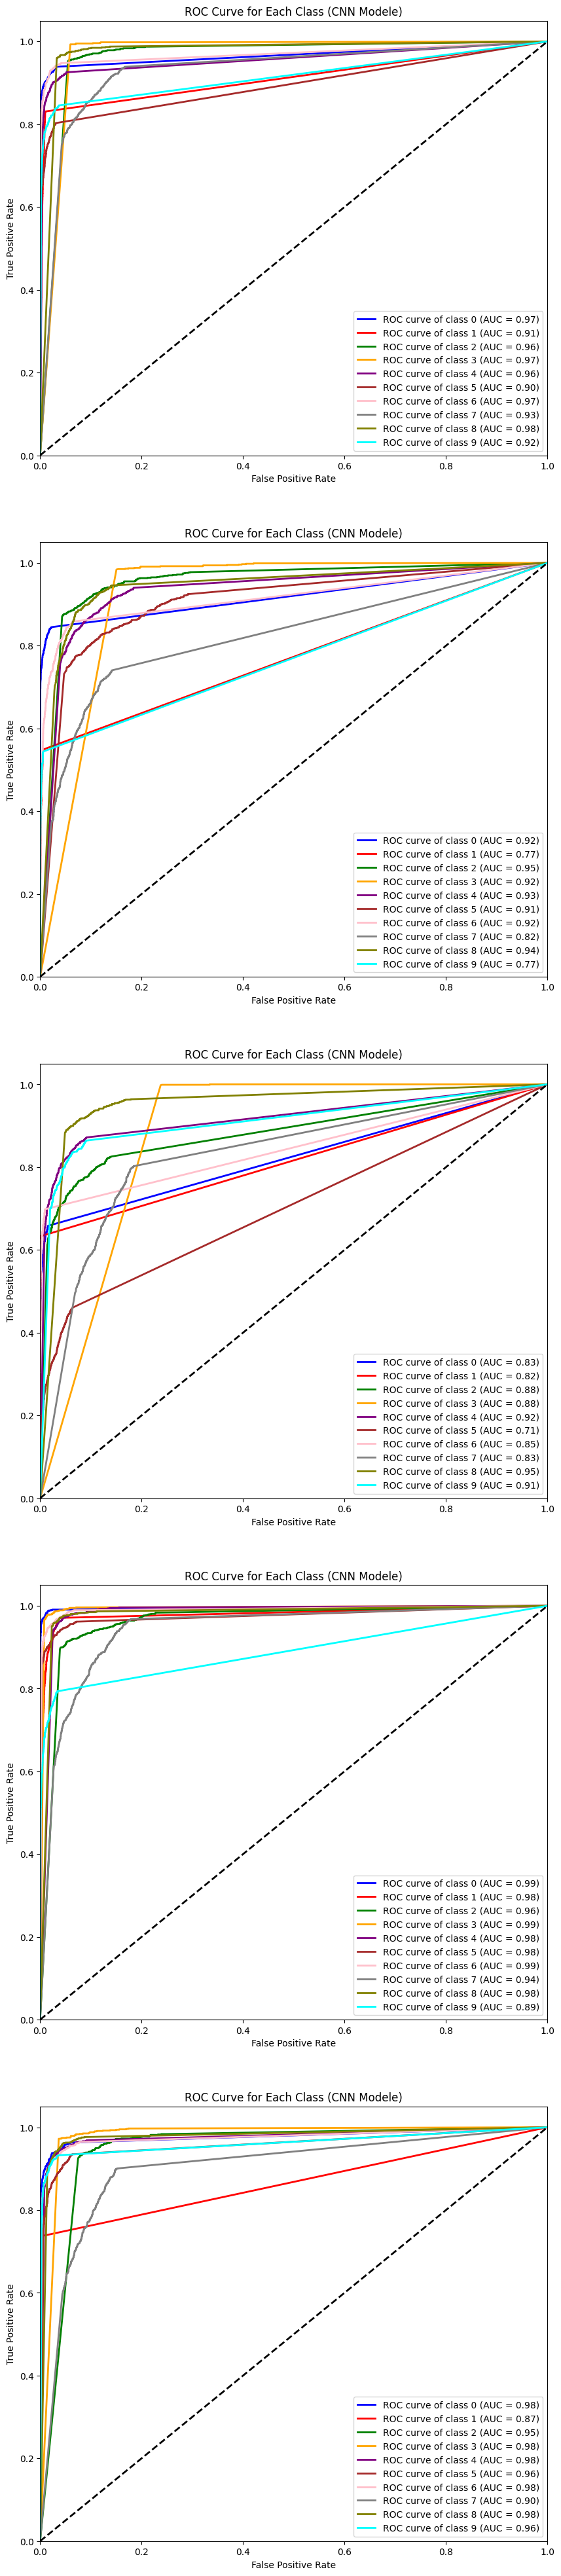

In [21]:
plt.figure(figsize=(10, 10*k_folds))

for fold in range (k_folds) :
    cnn_model = best_histories[fold][0]
    y_pred_cnn = cnn_model.predict(X_test_cnn)
    y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)

    # Binarize the output for ROC curve (one-vs-rest)
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    n_classes = y_test_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_cnn[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    plt.subplot(k_folds, 1, fold+1)

    # Plot ROC curves for each class
    #plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class (CNN Modele)')
    plt.legend(loc="lower right")
plt.show()